In [1]:
!pip install ssqueezepy
!pip install tqdm

In [3]:
# --- Set up directories ---

import os

# === Define input and output folders ===

folder_balldrop = r'C:\...\balldrop' #update the path to 'balldrop' folder
folder_AE = r'C:\...\AE' #update the path to 'AE' folder
folder_processed = r'C:\...\output' #update the path to 'output' folder

# =======================================

# Verify that input folders exist
for folder in [folder_balldrop, folder_AE]:
    if not os.path.exists(folder):
        raise FileNotFoundError(f"Input folder not found: {folder}")

# Create the output folder if it doesn't exist
os.makedirs(folder_processed, exist_ok=True)

# Confirm setup
print("Folder set-up completed.")


Folder set-up completed.


In [5]:
# --- Set up Ball Drop Experiment Properties ---

import math
import numpy as np

# === input here ===

# Physical constants and known parameters
mass = 3.52 / 1000                # Ball mass in kg
drop_height = 0.72                # Drop height in meters
g = 9.8                           # Gravitational acceleration in m/s²

# Material properties
density1, density2 = 8000, 2650   # Densities (kg/m³) of ball and rock (stainless steel & granite)
E1, E2 = 2e11, 6.2e10             # Young's modulus (Pa)
nu1, nu2 = 0.25, 0.3              # Poisson's ratio

# Initial conditions
radius = None                      # Ball radius in meters (to be calculated)
vf = None                          # Rebound velocity (set later)
v0 = (2 * g * drop_height) ** 0.5  # Impact velocity (free-fall)

# Source radius Brune constant
kappa = 2.34  # Geometry constant

# ==================================

# calculation

# Compute radius if not defined
if radius is None:
    volume = mass / density1
    radius = ((3 * volume) / (4 * math.pi)) ** (1/3)

# Compute rebound velocity if not defined
if vf is None:
    vf = -0.83 * v0  # McLaskey et al. (2015) rebound coefficient on granite

# Wave velocities in rock sample
v_s = np.sqrt(E2 / (2 * density2 * (1 + nu2)))  # S-wave velocity
v_p = np.sqrt((E2 * (1 - nu2)) / (density2 * (1 + nu2) * (1 - 2 * nu2)))  # P-wave velocity

# Velocity Constant (C_FM)
C_FM = v_p + v_s  # Averaged value (McLaskey et al., 2015)

# Hertzian contact duration constants
d1 = (1 - nu1**2) / (np.pi * E1)
d2 = (1 - nu2**2) / (np.pi * E2)
C = 4.53 * radius * ((4 * density1 * np.pi * (d1 + d2) / 3) ** 0.4)

# Contact duration
t_c = C * (v0 ** -0.2)         # in seconds
t_c_ms = t_c * 1000            # in milliseconds

# Momentum change
delta_v = v0 - vf
delta_p = mass * delta_v       # in N·s
delta_p_mNs = delta_p * 1000   # in mN·s

# Maximum force during impact
F_max = -1.92 * (density1**0.6) * ((d1 + d2)**-0.4) * (radius**2) * (v0**1.2)

# Dominant frequency of impact
f0 = 1 / t_c  # Hz

# --- Output Results ---
print(f"Ball radius: {radius:.4f} meters")
print(f"Impact velocity (v0): {v0:.2f} m/s")
print(f"Rebound velocity (vf): {vf:.2f} m/s")
print(f"S-wave velocity (v_s): {v_s:.2f} m/s")
print(f"P-wave velocity (v_p): {v_p:.2f} m/s")
print(f"Contact duration (t_c): {t_c_ms:.2f} ms")
print(f"Momentum change (delta_p): {delta_p:.2f} N·s")
print(f"Momentum change (delta_p_mNs): {delta_p_mNs:.2f} mN·s")
print(f"Velocity Constant (C_FM): {C_FM:.2f} m/s")
print(f"Maximum force during impact (F_max): {F_max:.2f} N")
print(f"Dominant frequency (f0): {f0:.2f} Hz")
print(f"Brune constant (kappa): {kappa:.2f}")


Ball radius: 0.0047 meters
Impact velocity (v0): 3.76 m/s
Rebound velocity (vf): -3.12 m/s
S-wave velocity (v_s): 2999.76 m/s
P-wave velocity (v_p): 5612.03 m/s
Contact duration (t_c): 0.03 ms
Momentum change (delta_p): 0.02 N·s
Momentum change (delta_p_mNs): 24.20 mN·s
Velocity Constant (C_FM): 8611.79 m/s
Maximum force during impact (F_max): -1401.32 N
Dominant frequency (f0): 28777.62 Hz
Brune constant (kappa): 2.34


In [7]:
# --- combining all balldrop test ---

import os
import pandas as pd
from tqdm import tqdm
import time

# === Define output path ===

output_filename = 'combined_balldrop.csv'
output_csv_path = os.path.join(folder_processed, output_filename)
os.makedirs(folder_processed, exist_ok=True)

# List all CSV files to process
csv_files = [f for f in os.listdir(folder_balldrop) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_balldrop}")

# =======================================

# Load existing file if available
if os.path.exists(output_csv_path):
    compiled_data = pd.read_csv(output_csv_path)
else:
    compiled_data = pd.DataFrame()

start_time = time.time()

# Track updated entries
updated_filenames = []

for csv_file in tqdm(csv_files, desc="Processing CSV files", unit="file"):
    file_path = os.path.join(folder_balldrop, csv_file)
    data = pd.read_csv(file_path)

    if not {'time_s', 'amplitude'}.issubset(data.columns):
        raise ValueError(f"Missing expected columns in {csv_file}")

    data = data[['time_s', 'amplitude']].copy()
    data['filename'] = csv_file

    updated_filenames.append(csv_file)

    # Remove previous rows for this file if 'filename' column exists
    if 'filename' in compiled_data.columns:
        compiled_data = compiled_data[compiled_data['filename'] != csv_file]

    # Append new data
    compiled_data = pd.concat([compiled_data, data], ignore_index=True)

# Finalize column order (only reorder known columns)
reordered_cols = ['filename', 'time_s', 'amplitude']
other_cols = [col for col in compiled_data.columns if col not in reordered_cols]
compiled_data = compiled_data[reordered_cols + other_cols]

# Save updated file
compiled_data.to_csv(output_csv_path, index=False)

# Print summary
elapsed_time = time.time() - start_time
print(f"Compiled CSV saved to: {output_csv_path}")
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"Columns in output: {compiled_data.columns.tolist()}")
print(compiled_data.head())


Processing CSV files: 100%|██████████████████████████████████████████████████████████| 19/19 [00:01<00:00, 17.62file/s]


Compiled CSV saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\combined_balldrop.csv
Time taken: 2.23 seconds
Columns in output: ['filename', 'time_s', 'amplitude']
    filename        time_s  amplitude
0  wf_00.csv  0.000000e+00       -4.0
1  wf_00.csv  1.000000e-07       -9.0
2  wf_00.csv  2.000000e-07       -1.0
3  wf_00.csv  3.000000e-07        0.0
4  wf_00.csv  4.000000e-07       -2.0


In [9]:
# --- Extract Waveform Number from Filename Column for data checking ---

import os
import pandas as pd

# === Define input path ===

input_filename = 'combined_balldrop.csv'
input_file_path = os.path.join(folder_processed, input_filename)

# =========================

# Load compiled data 
compiled_data = pd.read_csv(input_file_path)

# Split 'filename' into parts and extract waveform number 
split_cols = compiled_data['filename'].str.extract(r'([^_]+)_([^\.]+)\.(.+)')
split_cols.columns = ['prefix', 'waveform_num', 'extension']
compiled_data['waveform_num'] = split_cols['waveform_num'].astype(int)

# Save the updated DataFrame (overwrite original file) 
compiled_data.to_csv(input_file_path, index=False)

print("Updated DataFrame with waveform_num:")
print(compiled_data.head())


Updated DataFrame with waveform_num:
    filename        time_s  amplitude  waveform_num
0  wf_00.csv  0.000000e+00       -4.0             0
1  wf_00.csv  1.000000e-07       -9.0             0
2  wf_00.csv  2.000000e-07       -1.0             0
3  wf_00.csv  3.000000e-07        0.0             0
4  wf_00.csv  4.000000e-07       -2.0             0


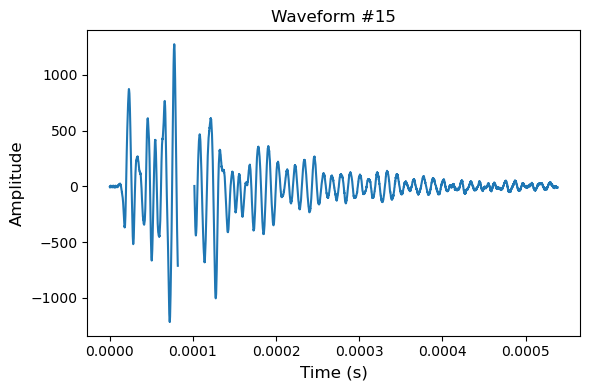

In [11]:
# --- Waveform Quality Check Plot ---

import os
import pandas as pd
import matplotlib.pyplot as plt

# === Input Parameters ===

input_filename = 'combined_balldrop.csv'
waveform_num_to_plot = 15  # Specify which waveform to plot

# ==================

# Load Data 
input_file_path = os.path.join(folder_processed, input_filename)
compiled_data = pd.read_csv(input_file_path)

# Filter for selected waveform 
filtered_data = compiled_data[compiled_data['waveform_num'] == waveform_num_to_plot]

# Extract time and amplitude 
time = filtered_data['time_s'].values
amplitude = filtered_data['amplitude'].values

# Plot waveform 
plt.figure(figsize=(6, 4))
plt.plot(time, amplitude)

#plt.xlim(1e-5, 4e-4)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.title(f'Waveform #{waveform_num_to_plot}', fontsize=12)

plt.tight_layout()
plt.show()


In [13]:
# --- Normalize Amplitude Between -1 and 1 for Each Waveform for data checking---

import os
import pandas as pd
import numpy as np

# === Parameters ===

input_filename = 'combined_balldrop.csv'
input_file_path = os.path.join(folder_processed, input_filename)

# ==================

# Normalization function 
def normalize_amplitude(amplitude):
    max_val = np.max(amplitude)
    min_val = np.min(amplitude)
    return np.zeros_like(amplitude) if max_val == min_val else 2 * ((amplitude - min_val) / (max_val - min_val)) - 1

# Load CSV 
try:
    compiled_data = pd.read_csv(input_file_path)
except FileNotFoundError:
    raise FileNotFoundError(f"File not found: {input_file_path}")

# Check required columns 
required_cols = {'waveform_num', 'amplitude'}
if not required_cols.issubset(compiled_data.columns):
    raise ValueError(f"Missing required columns: {required_cols - set(compiled_data.columns)}")

# Normalize amplitude 
print(f"{'Updating' if 'normalized_amplitude' in compiled_data.columns else 'Adding'} 'normalized_amplitude' column...")
compiled_data['normalized_amplitude'] = compiled_data.groupby('waveform_num')['amplitude'].transform(normalize_amplitude)

# Save updated CSV 
compiled_data.to_csv(input_file_path, index=False)
print(f"Normalized amplitude written to: {input_file_path}")

print(compiled_data.head())


Adding 'normalized_amplitude' column...
Normalized amplitude written to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\combined_balldrop.csv
    filename        time_s  amplitude  waveform_num  normalized_amplitude
0  wf_00.csv  0.000000e+00       -4.0             0              0.081041
1  wf_00.csv  1.000000e-07       -9.0             0              0.073606
2  wf_00.csv  2.000000e-07       -1.0             0              0.085502
3  wf_00.csv  3.000000e-07        0.0             0              0.086989
4  wf_00.csv  4.000000e-07       -2.0             0              0.084015


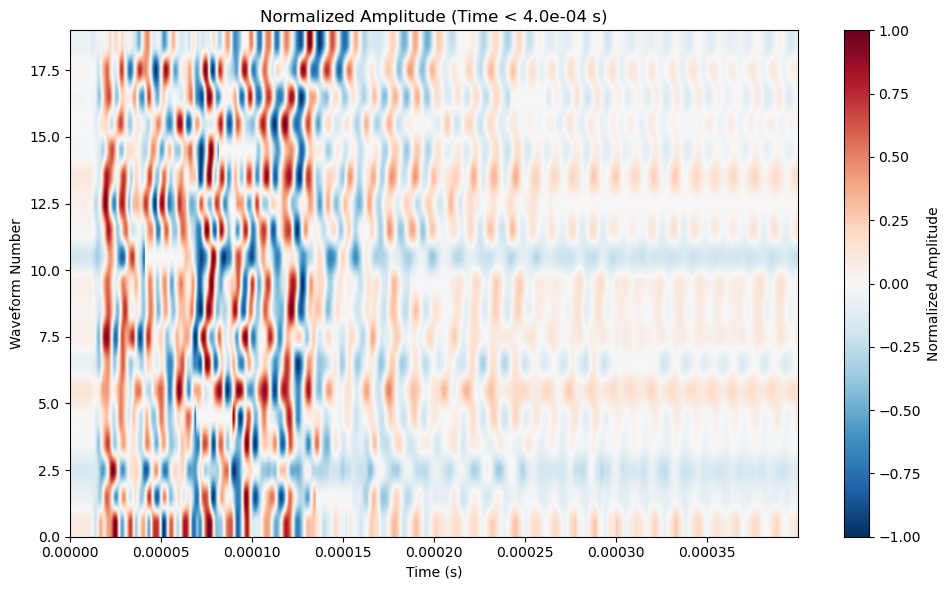

In [15]:
# --- Display Normalized Amplitude Over Time Using Imshow ---

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# === Parameters ===

# input file path
input_filename = 'combined_balldrop.csv'
input_file_path = os.path.join(folder_processed, input_filename)

# Filter data for time < x seconds for display
filtered_time = 4e-4   #define the specific time for display
filtered_data = compiled_data[compiled_data['time_s'] < filtered_time] 

# ==================

#  Load Data 
compiled_data = pd.read_csv(input_file_path)

# Pivot data for imshow: waveform_num (rows), time_s (columns), normalized_amplitude (values) 
pivot = filtered_data.pivot(index='waveform_num', columns='time_s', values='normalized_amplitude').fillna(0)
pivot_array = pivot.values  # Convert to numpy array

# Set plot extent based on data ranges 
extent = [
    filtered_data['time_s'].min(),
    filtered_data['time_s'].max(),
    filtered_data['waveform_num'].min(),
    filtered_data['waveform_num'].max()
]

# Plot using imshow 
plt.figure(figsize=(10, 6))
plt.imshow(pivot_array, aspect='auto', cmap='RdBu_r', origin='lower',
           extent=extent, vmin=-1, vmax=1)

# Labels and title 
plt.xlabel('Time (s)')
plt.ylabel('Waveform Number')
plt.title(f'Normalized Amplitude (Time < {filtered_time:.1e} s)')

# Colorbar 
cbar = plt.colorbar()
cbar.set_label('Normalized Amplitude')

plt.tight_layout()
plt.show()


FFT spectrum saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\spectrum_balldrop_windowed_fft.csv


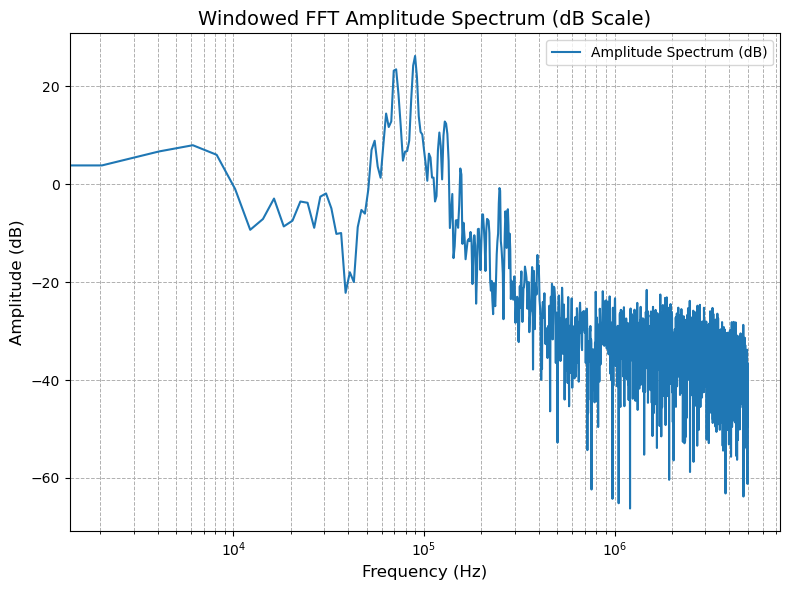

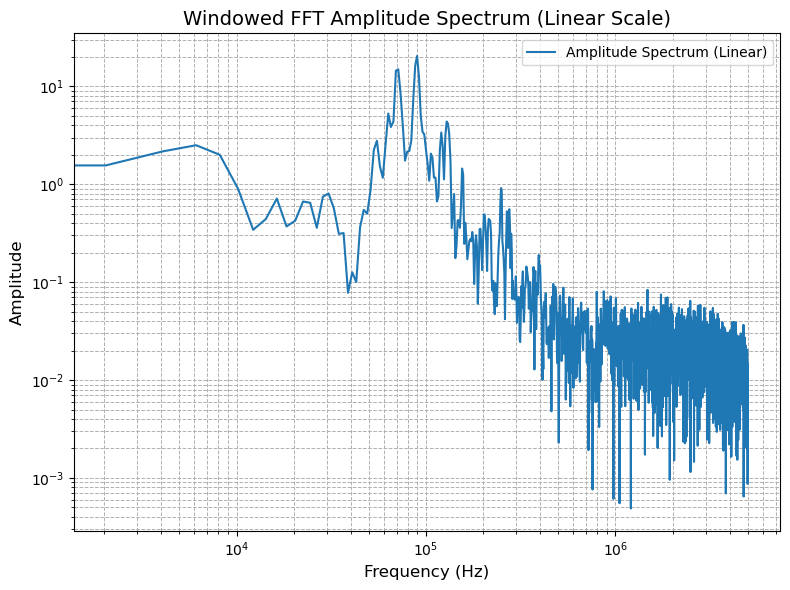

In [21]:
# --- Perform Windowed FFT on Selected AE Waveform ---

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal.windows import blackmanharris

# === set up input and output ===

input_filename = 'combined_balldrop.csv'
output_filename = 'spectrum_balldrop_windowed_fft.csv'
waveform_to_plot = 9  # define waveform with highest SNR
time_min, time_max = 1e-5, 5e-4  # Time window for analysis (in seconds)

# ===============================

# Load and Filter Data 
input_file_path = os.path.join(folder_processed, input_filename)
output_file_path = os.path.join(folder_processed, output_filename)

data = pd.read_csv(input_file_path).fillna(0)

# Select the specific waveform
waveform_data = data[data['waveform_num'] == waveform_to_plot]

if waveform_data.empty:
    raise ValueError(f"No data found for waveform_num={waveform_to_plot}")

# Restrict to defined time range
waveform_data = waveform_data[(waveform_data['time_s'] >= time_min) & (waveform_data['time_s'] <= time_max)]

# Extract time and amplitude arrays
time = waveform_data['time_s'].values
amplitude = waveform_data['amplitude'].values

if len(time) < 2:
    raise ValueError("Insufficient data points for FFT.")

# Apply Blackman-Harris Window 
window = blackmanharris(len(amplitude))
amplitude_windowed = amplitude * window

# Compute FFT 
dt = time[1] - time[0]  # Sampling interval
frequencies = np.fft.rfftfreq(len(time), d=dt)  # Frequency axis
fft_result = np.fft.rfft(amplitude_windowed)  # FFT
amplitude_spectrum = np.abs(fft_result) / len(time)  # Normalize amplitude

# Convert to dB scale for visualization
epsilon = 1e-12  # To avoid log(0)
amplitude_spectrum_db = 20 * np.log10(amplitude_spectrum + epsilon)

# Save Spectrum to CSV
spectrum_df = pd.DataFrame({
    'frequency': frequencies,
    'amplitude': amplitude_spectrum
})
spectrum_df.to_csv(output_file_path, index=False)
print(f"FFT spectrum saved to: {output_file_path}")

# Plot: Spectrum in dB scale (semilog-x) 
plt.figure(figsize=(8, 6))
plt.semilogx(frequencies, amplitude_spectrum_db, label='Amplitude Spectrum (dB)', linewidth=1.5)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude (dB)", fontsize=12)
plt.title("Windowed FFT Amplitude Spectrum (dB Scale)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

# Plot: Spectrum in linear scale (log-log) 
plt.figure(figsize=(8, 6))
plt.loglog(frequencies, amplitude_spectrum, label='Amplitude Spectrum (Linear)', linewidth=1.5)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude", fontsize=12)
plt.title("Windowed FFT Amplitude Spectrum (Linear Scale)", fontsize=14)
plt.legend(fontsize=10)
plt.grid(which='both', linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()


Corrected Hertzian force-time function saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\corrected_hertzian_force.csv
         time_s  force_corrected  force_corrected_hat
0  0.000000e+00    -0.000000e+00            -0.000000
1  1.000000e-07    -1.373516e-07            -0.000006
2  2.000000e-07    -3.884650e-07            -0.000016
3  3.000000e-07    -7.135829e-07            -0.000029
4  4.000000e-07    -1.098476e-06            -0.000045


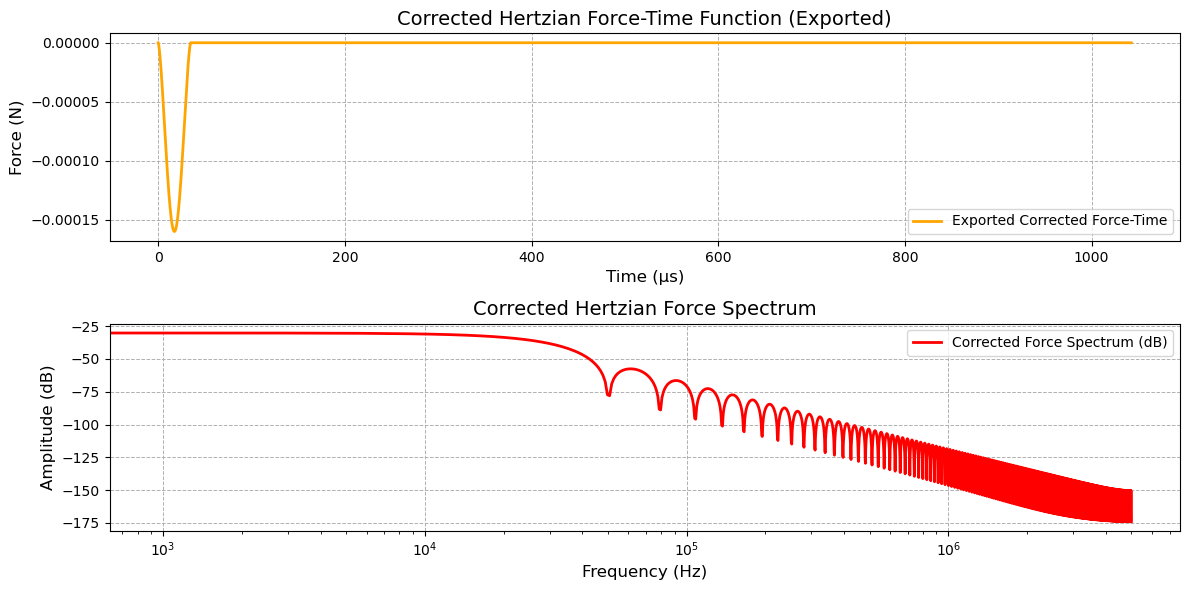

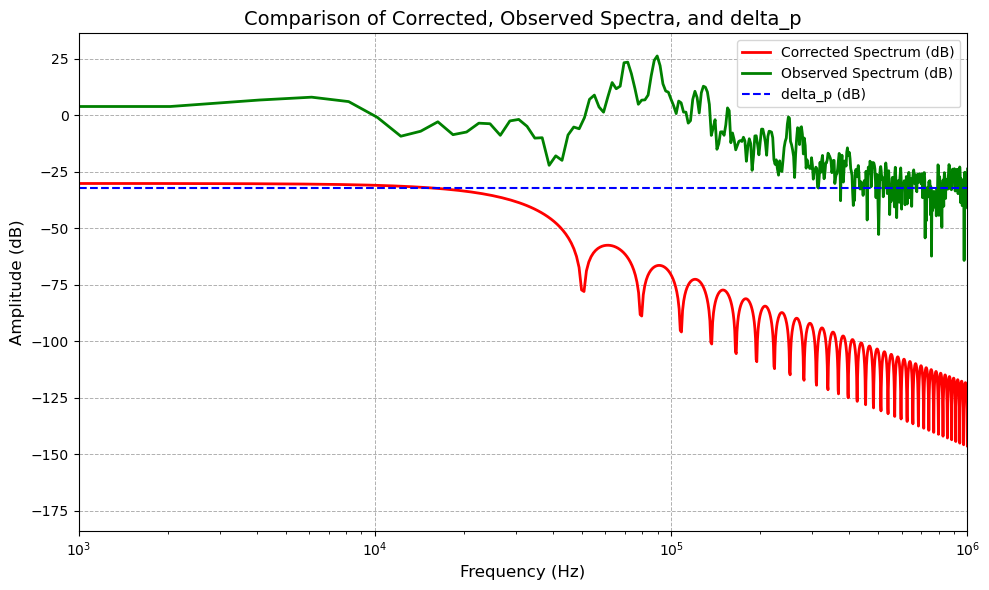

In [37]:
# --- Calculate and Export Corrected Theoretical Hertzian Force-Time Function ---

# --- F_max, t_c, delta_p, f0 are defined in previous cell---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# === File Paths ===

input_filename = 'spectrum_balldrop_windowed_fft.csv'
output_filename = 'corrected_hertzian_force.csv'

input_file_path = os.path.join(folder_processed, input_filename)
output_file_path = os.path.join(folder_processed, output_filename)

# =====================================

# --- Hertzian Force-Time Function ---
def hertzian_force(t, F_max, t_c):
    """Hertzian contact force model: nonzero only for t <= t_c."""
    sine_vals = np.sin(np.pi * t / t_c)
    return np.where(t <= t_c, F_max * np.maximum(sine_vals, 0)**1.5, 0)

# Load Observed FFT Spectrum 
spectrum_data = pd.read_csv(input_file_path)
frequency_obs = spectrum_data['frequency'].values
amplitude_obs = spectrum_data['amplitude'].values

# Generate Time Array 
dt = 1e-7  # 100 ns
time = np.arange(0, 30 * t_c + dt, dt)

# Compute Raw Theoretical Force-Time Waveform 
force_raw = hertzian_force(time, F_max, t_c)

# Compute FFT of Raw Force 
frequencies = np.fft.rfftfreq(len(time), d=dt)
force_spectrum = np.abs(np.fft.rfft(force_raw))

# Apply Correction Factor to Match delta_p at Low Frequencies 
low_freq_indices = np.where(frequencies < f0)[0]
low_freq_avg = np.mean(force_spectrum[low_freq_indices])
correction_factor = delta_p / low_freq_avg

force_corrected = force_raw * correction_factor
force_corrected_hat = force_corrected / delta_p  # Normalized waveform

# Compute corrected FFT
force_spectrum_corrected = np.abs(np.fft.rfft(force_corrected))

# Save to CSV 
corrected_force_df = pd.DataFrame({
    'time_s': time,
    'force_corrected': force_corrected,
    'force_corrected_hat': force_corrected_hat
})
corrected_force_df.to_csv(output_file_path, index=False)

print(f"Corrected Hertzian force-time function saved to: {output_file_path}")
print(corrected_force_df.head())

# Plotting exported data

# Load Exported Corrected Data 
exported_file = os.path.join(folder_processed, 'corrected_hertzian_force.csv')
corrected_data = pd.read_csv(exported_file)

time_exported = corrected_data['time_s'].values
force_corrected_exported = corrected_data['force_corrected'].values  # Column name was previously 'force_corrected_N'

# Plot: Time-Domain Check 
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_exported * 1e6, force_corrected_exported, color='orange', linewidth=2,
         label="Exported Corrected Force-Time")
plt.xlabel("Time (µs)", fontsize=12)
plt.ylabel("Force (N)", fontsize=12)
plt.title("Corrected Hertzian Force-Time Function (Exported)", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.7)

# Plot: Frequency-Domain Spectrum (Precomputed from earlier step) 
plt.subplot(2, 1, 2)
plt.semilogx(frequencies, 20 * np.log10(force_spectrum_corrected + 1e-12), color='red', linewidth=2,
             label="Corrected Force Spectrum (dB)")
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude (dB)", fontsize=12)
plt.title("Corrected Hertzian Force Spectrum", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.7)

plt.tight_layout()
plt.show()

# Overlay with Observed Spectrum and delta_p
plt.figure(figsize=(10, 6))
plt.semilogx(frequencies, 20 * np.log10(force_spectrum_corrected + 1e-12), color='red', linewidth=2,
             label="Corrected Spectrum (dB)")
plt.semilogx(frequency_obs, 20 * np.log10(amplitude_obs  + 1e-12), color='green', linewidth=2,
             label="Observed Spectrum (dB)")
plt.axhline(20 * np.log10(delta_p), color='blue', linestyle='--', label="delta_p (dB)")
plt.xlim(1e3, 1e6)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude (dB)", fontsize=12)
plt.title("Comparison of Corrected, Observed Spectra, and delta_p", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()



✅ Instrument responses saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\instrument_response_results.csv


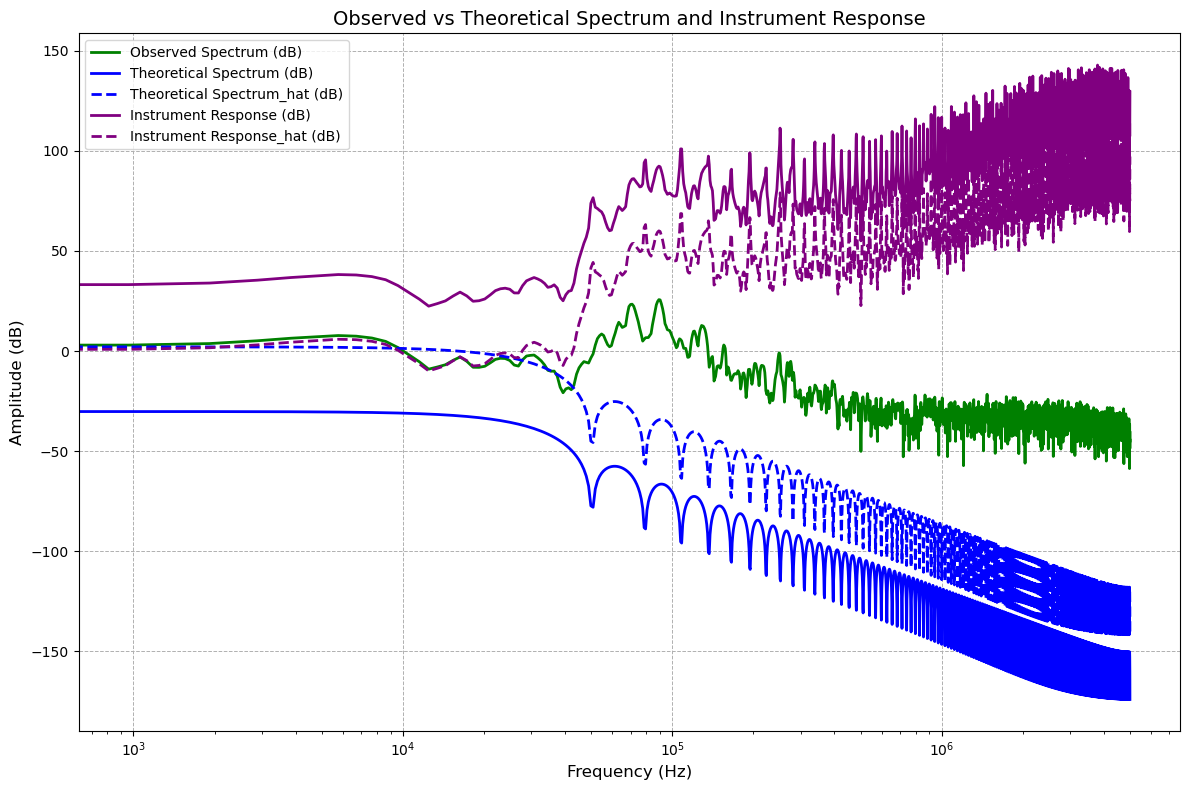

    frequency  instrument_response  instrument_response_hat
0     0.00000            41.431826                 1.002587
1   959.14061            45.665516                 1.105036
2  1918.28122            49.991218                 1.209711
3  2877.42183            58.884577                 1.424917
4  3836.56244            68.622283                 1.660555


In [53]:
# --- Calculate and Save Instrument Response ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File Paths 
observed_file = os.path.join(folder_processed, 'spectrum_balldrop_windowed_fft.csv')
theoretical_file = os.path.join(folder_processed, 'corrected_hertzian_force.csv')
output_file = os.path.join(folder_processed, 'instrument_response_results.csv')

# Load Observed Spectrum 
observed_data = pd.read_csv(observed_file)
freq_obs = observed_data['frequency'].values
ampl_obs = observed_data['amplitude'].values

# Load Theoretical Force-Time and Compute Spectrum 
theoretical_data = pd.read_csv(theoretical_file)
dt = 1e-7  # sampling interval
time_array = theoretical_data['time_s'].values
force_corrected = theoretical_data['force_corrected'].values
force_corrected_hat = theoretical_data['force_corrected_hat'].values

freq_theo = np.fft.rfftfreq(len(time_array), d=dt)
spec_theo = np.abs(np.fft.rfft(force_corrected))
spec_theo_hat = np.abs(np.fft.rfft(force_corrected_hat))

# Interpolate Observed Spectrum to Match Theoretical Frequencies 
ampl_obs_resampled = np.interp(freq_theo, freq_obs, ampl_obs)

# Avoid division by zero 
epsilon = 1e-12
spec_theo_safe = np.where(spec_theo == 0, epsilon, spec_theo)
spec_theo_hat_safe = np.where(spec_theo_hat == 0, epsilon, spec_theo_hat)

# Compute Instrument Responses 
instr_response = ampl_obs_resampled / spec_theo_safe
instr_response_hat = ampl_obs_resampled / spec_theo_hat_safe

# Save to CSV 
instrument_response_df = pd.DataFrame({
    'frequency': freq_theo,
    'instrument_response': instr_response,
    'instrument_response_hat': instr_response_hat
})
instrument_response_df.to_csv(output_file, index=False)
print(f"✅ Instrument responses saved to: {output_file}")

# Plotting 
plt.figure(figsize=(12, 8))

plt.semilogx(freq_theo, 20 * np.log10(ampl_obs_resampled + epsilon), label="Observed Spectrum (dB)", linewidth=2, color='green')
plt.semilogx(freq_theo, 20 * np.log10(spec_theo_safe + epsilon), label="Theoretical Spectrum (dB)", linewidth=2, color='blue')
plt.semilogx(freq_theo, 20 * np.log10(spec_theo_hat_safe + epsilon), label="Theoretical Spectrum_hat (dB)", linestyle='--', linewidth=2, color='blue')

plt.semilogx(freq_theo, 20 * np.log10(instr_response + epsilon), label="Instrument Response (dB)", linewidth=2, color='purple')
plt.semilogx(freq_theo, 20 * np.log10(instr_response_hat + epsilon), label="Instrument Response_hat (dB)", linestyle='--', linewidth=2, color='purple')

plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude (dB)", fontsize=12)
plt.title("Observed vs Theoretical Spectrum and Instrument Response", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()

#  Preview CSV Output 
print(instrument_response_df.head())


In [39]:
# --- Extract and Compile AE Waveforms from Folder ---

import os
import pandas as pd
from tqdm import tqdm
import time

# --- Output File ---
output_filename = 'AE_experiment.csv'
output_file_path = os.path.join(folder_processed, output_filename)

# List Input Files 
csv_files = [f for f in os.listdir(folder_AE) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {folder_AE}")

# Initialize Compilation 
compiled_data = pd.DataFrame()
start_time = time.time()

# Loop Through Files and Compile 
for csv_file in tqdm(csv_files, desc="Processing AE CSV files", unit="file"):
    file_path = os.path.join(folder_AE, csv_file)
    data = pd.read_csv(file_path)

    # Keep only expected columns
    data = data[['time_s', 'amplitude']]

    # Add identifier for waveform source
    data['filename'] = csv_file

    compiled_data = pd.concat([compiled_data, data], ignore_index=True)

# Final Formatting 
compiled_data = compiled_data[['filename', 'time_s', 'amplitude']]

# Save Compiled Data 
compiled_data.to_csv(output_file_path, index=False)
elapsed_time = time.time() - start_time

# Summary Output 
print(f"Compiled AE waveforms saved to: {output_file_path}")
print(f"Time taken: {elapsed_time:.2f} seconds")
print(f"Columns in output: {compiled_data.columns.tolist()}")
print(compiled_data.head())


Processing AE CSV files: 100%|███████████████████████████████████████████████████| 2999/2999 [02:50<00:00, 17.55file/s]


Compiled AE waveforms saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\AE_experiment.csv
Time taken: 184.23 seconds
Columns in output: ['filename', 'time_s', 'amplitude']
        filename        time_s  amplitude
0  wf_098270.csv  0.000000e+00        1.0
1  wf_098270.csv  1.000000e-07       -1.0
2  wf_098270.csv  2.000000e-07       -5.0
3  wf_098270.csv  3.000000e-07       -3.0
4  wf_098270.csv  4.000000e-07       -1.0


In [41]:
# --- Extract 'waveform_num' from Filename Column in AE Data ---

import os
import pandas as pd

# --- Define File Paths ---
input_filename = 'AE_experiment.csv'
input_file_path = os.path.join(folder_processed, input_filename)

# Load Data 
compiled_data = pd.read_csv(input_file_path)

# Extract waveform number from "filename" 
split = compiled_data['filename'].str.extract(r'([^_]+)_([^\.]+)\.(.+)')
split.columns = ['prefix', 'waveform_num', 'extension']

# Assign waveform_num to main DataFrame 
compiled_data['waveform_num'] = split['waveform_num']

# Convert waveform_num to integer for easier sorting/analysis
compiled_data['waveform_num'] = pd.to_numeric(compiled_data['waveform_num'], errors='coerce').astype('Int64')

# Save Updated Data 
compiled_data.to_csv(input_file_path, index=False)

# Confirm Update 
print(f"Updated data with 'waveform_num' saved to: {input_file_path}")
print(compiled_data.head())


Updated data with 'waveform_num' saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\AE_experiment.csv
        filename        time_s  amplitude  waveform_num
0  wf_098270.csv  0.000000e+00        1.0         98270
1  wf_098270.csv  1.000000e-07       -1.0         98270
2  wf_098270.csv  2.000000e-07       -5.0         98270
3  wf_098270.csv  3.000000e-07       -3.0         98270
4  wf_098270.csv  4.000000e-07       -1.0         98270


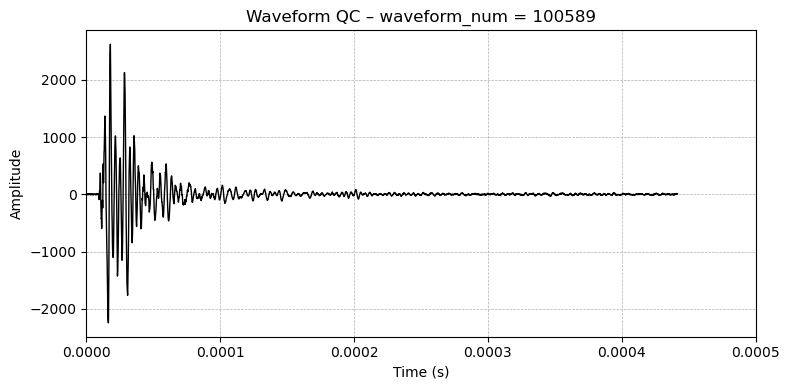

In [43]:
# --- Waveform Quality Control Plot ---

import os
import pandas as pd
import matplotlib.pyplot as plt

# --- Parameters ---
input_filename = 'AE_experiment.csv'
input_file_path = os.path.join(folder_processed, input_filename)
waveform_num_to_plot = 100589  # Update as needed

# Load Data 
compiled_data = pd.read_csv(input_file_path)

# Filter for Specific Waveform 
filtered = compiled_data[compiled_data['waveform_num'] == waveform_num_to_plot]

if filtered.empty:
    print(f"No data found for waveform_num = {waveform_num_to_plot}")
else:
    time = filtered['time_s'].values
    amplitude = filtered['amplitude'].values

    # Plot 
    plt.figure(figsize=(8, 4))
    plt.plot(time, amplitude, label=f'Waveform {waveform_num_to_plot}', color='black', linewidth=1)

    plt.xlim(0, 5e-4)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title(f"Waveform QC – waveform_num = {waveform_num_to_plot}")
    plt.grid(True, linestyle='--', linewidth=0.5)
    

    plt.tight_layout()
    plt.show()


In [45]:
# --- Data QC -- Normalize Amplitude per Waveform ---

import os
import pandas as pd
import numpy as np

# --- File Paths ---
input_filename = 'AE_experiment.csv'
input_file_path = os.path.join(folder_processed, input_filename)

# Load Data 
compiled_data = pd.read_csv(input_file_path)

# Check for Existing Column 
if 'normalized_amplitude' in compiled_data.columns:
    print(" 'normalized_amplitude' column already exists. Updating values...")
else:
    print(" 'normalized_amplitude' column not found. Adding new column...")

# Normalization Function 
def normalize_amplitude(amplitude):
    max_val, min_val = np.max(amplitude), np.min(amplitude)
    return np.zeros_like(amplitude) if max_val == min_val else 2 * ((amplitude - min_val) / (max_val - min_val)) - 1

# Apply Grouped Normalization 
compiled_data['normalized_amplitude'] = (
    compiled_data
    .groupby('waveform_num')['amplitude']
    .transform(normalize_amplitude)
)

# Save Updated File 
compiled_data.to_csv(input_file_path, index=False)
print(f"Normalized amplitude saved to: {input_file_path}")

# Preview Result 
print(compiled_data.head())


 'normalized_amplitude' column not found. Adding new column...
Normalized amplitude saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\AE_experiment.csv
        filename        time_s  amplitude  waveform_num  normalized_amplitude
0  wf_098270.csv  0.000000e+00        1.0         98270             -0.111111
1  wf_098270.csv  1.000000e-07       -1.0         98270             -0.222222
2  wf_098270.csv  2.000000e-07       -5.0         98270             -0.444444
3  wf_098270.csv  3.000000e-07       -3.0         98270             -0.333333
4  wf_098270.csv  4.000000e-07       -1.0         98270             -0.222222


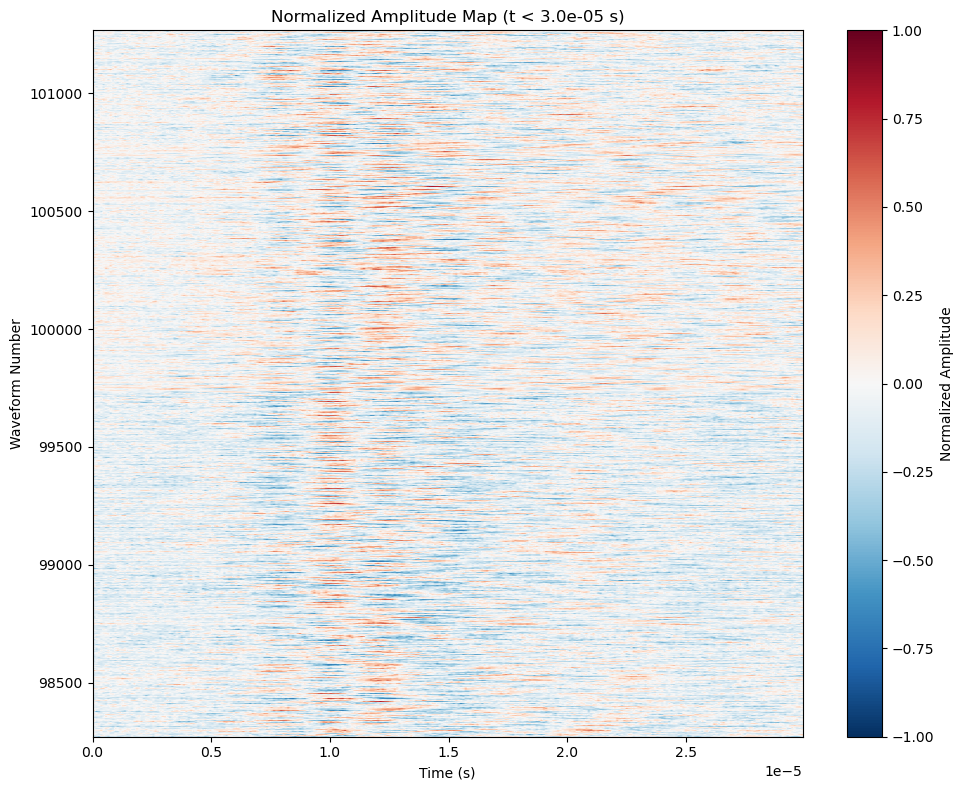

In [47]:
# --- QC Visualization of Normalized Amplitudes Using imshow ---

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- File Parameters ---
input_filename = 'AE_experiment.csv'
input_file_path = os.path.join(folder_processed, input_filename)
time_threshold = 3e-5  # Seconds; update if needed

# Load Data 
compiled_data = pd.read_csv(input_file_path)

# Filter for Early-Time Window 
filtered_data = compiled_data[compiled_data['time_s'] < time_threshold]

# Pivot for imshow: waveform_num (rows) × time_s (columns) 
pivot = filtered_data.pivot(index='waveform_num', columns='time_s', values='normalized_amplitude').fillna(0)
pivot_array = pivot.to_numpy()

# Set Plot Extent for Accurate Axes 
extent = [
    filtered_data['time_s'].min(),
    filtered_data['time_s'].max(),
    filtered_data['waveform_num'].min(),
    filtered_data['waveform_num'].max()
]

# Plot Heatmap 
plt.figure(figsize=(10, 8))
plt.imshow(pivot_array, aspect='auto', cmap='RdBu_r', origin='lower',
           extent=extent, vmin=-1, vmax=1)

plt.xlabel('Time (s)')
plt.ylabel('Waveform Number')
plt.title(f'Normalized Amplitude Map (t < {time_threshold:.1e} s)')

# Add Colorbar 
cbar = plt.colorbar()
cbar.set_label('Normalized Amplitude')

plt.tight_layout()
plt.show()


In [49]:
# --- Batch Processing of AE Windowed FFT and CSV Export ---

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal.windows import blackmanharris

# --- File Paths ---
input_filename = 'AE_experiment.csv'
output_filename = 'AE_windowed_fft_results.csv'
input_file_path = os.path.join(folder_processed, input_filename)
output_file_path = os.path.join(folder_processed, output_filename)

# --- Signal Range for Analysis (seconds) ---
signal_start, signal_end = 0.5e-5, 4.5e-4 #modify if needed

# Load Data 
compiled_data = pd.read_csv(input_file_path)

# Verify Required Columns
if 'waveform_num' not in compiled_data.columns:
    raise ValueError("'waveform_num' column is missing from the input data.")

# Initialize Storage 
all_fft_results = []

# Loop Over Unique Waveforms 
for waveform_num in tqdm(compiled_data['waveform_num'].unique(), desc="Processing waveforms", unit="waveform"):
    wf_data = compiled_data[compiled_data['waveform_num'] == waveform_num]
    wf_data = wf_data[(wf_data['time_s'] >= signal_start) & (wf_data['time_s'] <= signal_end)]

    if wf_data.empty or len(wf_data) < 2:
        continue

    time = wf_data['time_s'].values
    amplitude = np.nan_to_num(wf_data['amplitude'].values)

    # Apply Blackman-Harris Window 
    window = blackmanharris(len(amplitude))
    amp_windowed = amplitude * window

    # FFT Calculation 
    dt = time[1] - time[0]
    freq = np.fft.rfftfreq(len(time), d=dt)
    fft_result = np.fft.rfft(amp_windowed)
    amp_spectrum = np.abs(fft_result) / len(time)

    # Append to results list 
    all_fft_results.append(pd.DataFrame({
        'waveform_num': waveform_num,
        'frequency': freq,
        'amplitude': amp_spectrum
    }))

# Concatenate all results 
final_fft_df = pd.concat(all_fft_results, ignore_index=True)

# Save to CSV 
final_fft_df.to_csv(output_file_path, index=False)
print(f"Batch windowed FFT results saved to: {output_file_path}")

# Preview 
print("Preview of the saved results:")
print(final_fft_df.head())


Processing waveforms: 100%|██████████████████████████████████████████████████| 2999/2999 [00:37<00:00, 80.68waveform/s]


Batch windowed FFT results saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\AE_windowed_fft_results.csv
Preview of the saved results:
   waveform_num     frequency  amplitude
0         98270      0.000000   0.019950
1         98270  15384.615385   0.046260
2         98270  30769.230769   0.028694
3         98270  46153.846154   0.072181
4         98270  61538.461538   0.073089


M0 and Mw results saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\moment_magnitude_results.csv
Preview:
   waveform_num   mean_M0  moment_magnitude
0         98270  0.129994         -6.657717
1         98271  4.294337         -5.645069
2         98272  0.316976         -6.399649
3         98273  0.141002         -6.634184
4         98274  0.940819         -6.084663


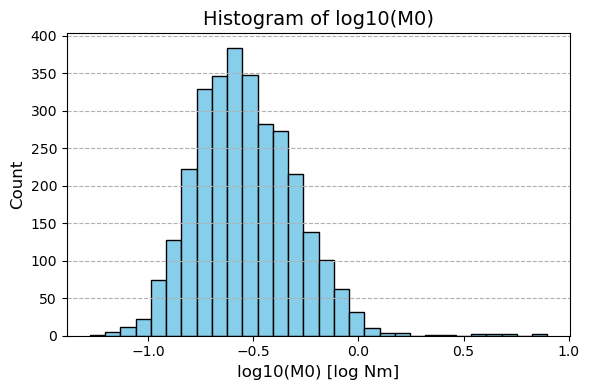

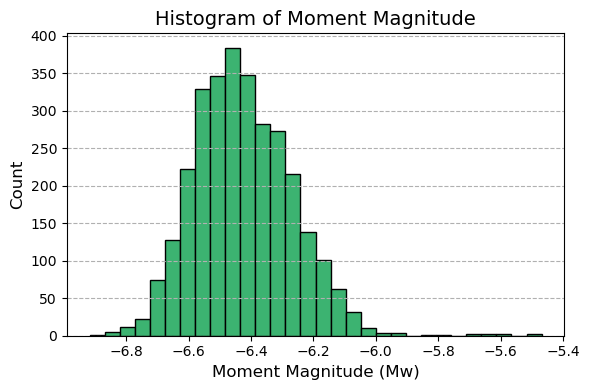

In [55]:
# --- Compute Seismic Moment (M0) and Moment Magnitude (Mw) ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Load Instrument Response (hat) ===
instrument_file = os.path.join(folder_processed, 'instrument_response_results.csv')
df_instr = pd.read_csv(instrument_file)
freq_ext = df_instr['frequency'].values
instr_hat = df_instr['instrument_response_hat'].values

# Load AE Spectrum 
ae_file = os.path.join(folder_processed, 'AE_windowed_fft_results.csv')
df_ae = pd.read_csv(ae_file)

# =================================================

# Initialize Storage 
waveform_nums, M0_list, Mw_list = [], [], []

# Loop Over Unique Waveforms 
for wf_num in df_ae['waveform_num'].unique():
    ae_data = df_ae[df_ae['waveform_num'] == wf_num]

    if ae_data.empty:
        continue

    freq_ae = ae_data['frequency'].values
    amp_ae = ae_data['amplitude'].values

    # Interpolate AE spectrum to match instrument response frequencies
    amp_interp = np.interp(freq_ext, freq_ae, amp_ae)

    # Avoid division by zero
    amp_interp = np.where(amp_interp == 0, 1e-12, amp_interp)

    # Compute spectral ratio and M0
    ratio = instr_hat / amp_interp
    M0 = delta_p * C_FM / ratio

    # Store mean M0 and compute Mw
    mean_M0 = np.mean(M0)
    waveform_nums.append(wf_num)
    M0_list.append(mean_M0)

    Mw = (2 / 3) * np.log10(mean_M0) - 6.067
    Mw_list.append(Mw)

# Save Results 
output_file = os.path.join(folder_processed, 'moment_magnitude_results.csv')
results_df = pd.DataFrame({
    'waveform_num': waveform_nums,
    'mean_M0': M0_list,
    'moment_magnitude': Mw_list
})
results_df.to_csv(output_file, index=False)

print(f"M0 and Mw results saved to: {output_file}")
print("Preview:")
print(results_df.head())

# --- Plotting results ---

# Plot Histogram of log10(M0) 
plt.figure(figsize=(6, 4))
plt.hist(np.log10(M0_list), bins=30, color='skyblue', edgecolor='black')
plt.xlabel("log10(M0) [log Nm]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of log10(M0)", fontsize=14)
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Plot Histogram of Mw 
plt.figure(figsize=(6, 4))
plt.hist(Mw_list, bins=30, color='mediumseagreen', edgecolor='black')
plt.xlabel("Moment Magnitude (Mw)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Histogram of Moment Magnitude", fontsize=14)
plt.grid(True, axis='y', linestyle='--')
plt.tight_layout()
plt.show()


In [57]:
# --- Calculation of True Spectra for All AE Waveforms ---

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# === File Paths ===

ae_file = os.path.join(folder_processed, 'AE_windowed_fft_results.csv')
instr_file = os.path.join(folder_processed, 'instrument_response_results.csv')
output_file = os.path.join(folder_processed, 'true_spectrum_results.csv')

# =======================================

# Load Data 
df_ae = pd.read_csv(ae_file)
df_instr = pd.read_csv(instr_file)

# Extract Instrument Response 
freq_instr = df_instr['frequency'].values
instr_response = df_instr['instrument_response'].values
instr_response_safe = np.where(instr_response == 0, 1e-12, instr_response)  # Avoid division by zero

# Initialize Storage 
true_spectra_list = []

# Process Each Waveform---
for wf_num in tqdm(df_ae['waveform_num'].unique(), desc="Processing waveforms", unit="waveform"):
    df_wf = df_ae[df_ae['waveform_num'] == wf_num]

    if df_wf.empty:
        continue

    freq_ae = df_wf['frequency'].values
    amp_ae = df_wf['amplitude'].values

    # Interpolate AE spectrum onto instrument frequency grid
    amp_interp = np.interp(freq_instr, freq_ae, amp_ae)

    # Compute true spectrum
    true_amp = amp_interp / instr_response_safe

    # Store result
    df_true = pd.DataFrame({
        'waveform_num': wf_num,
        'frequency': freq_instr,
        'true_spectrum': true_amp
    })

    true_spectra_list.append(df_true)

# Save Results---
df_combined = pd.concat(true_spectra_list, ignore_index=True)
df_combined.to_csv(output_file, index=False)

print(f"True spectra saved to: {output_file}")
print("\n Preview:")
print(df_combined.head())


Processing waveforms: 100%|█████████████████████████████████████████████████| 2999/2999 [00:22<00:00, 132.10waveform/s]


True spectra saved to: C:\Users\edoma\OneDrive - The Pennsylvania State University\Documents\python\corner_freq\processed\output\true_spectrum_results.csv

 Preview:
   waveform_num   frequency  true_spectrum
0         98270     0.00000       0.000482
1         98270   959.14061       0.000473
2         98270  1918.28122       0.000465
3         98270  2877.42183       0.000422
4         98270  3836.56244       0.000386


C:\Users\edoma\AppData\Local\Temp\ipykernel_18788\4062431665.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ae_filtered.loc[:, "amplitude_dB"] = 20 * np.log10(amplitude)
C:\Users\edoma\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Waveform 101108:
Δp_eq (log10): -5.09e+00
Mean M0 (log10): -1.16e+00
Fitted M0: 2.03e-05
Fitted f0: 390304.93 Hz
Fitted gamma: 2.45
Source radius: 0.0029 m



C:\Users\edoma\AppData\Local\Temp\ipykernel_18788\4062431665.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ae_filtered.loc[:, "amplitude_dB"] = 20 * np.log10(amplitude)
C:\Users\edoma\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Waveform 99998:
Δp_eq (log10): -4.44e+00
Mean M0 (log10): -5.07e-01
Fitted M0: 1.88e-04
Fitted f0: 261447.39 Hz
Fitted gamma: 3.10
Source radius: 0.0043 m



C:\Users\edoma\AppData\Local\Temp\ipykernel_18788\4062431665.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ae_filtered.loc[:, "amplitude_dB"] = 20 * np.log10(amplitude)
C:\Users\edoma\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Waveform 100182:
Δp_eq (log10): -3.86e+00
Mean M0 (log10): 7.48e-02
Fitted M0: 7.59e-04
Fitted f0: 156760.63 Hz
Fitted gamma: 3.06
Source radius: 0.0071 m



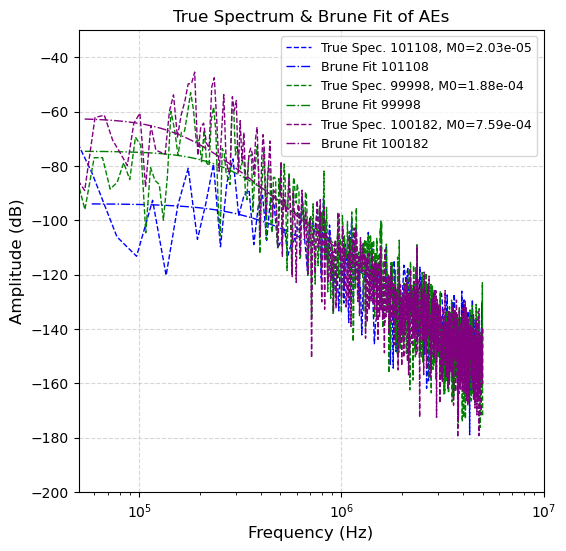

In [59]:
# --- Plot Brune model fit with true AE spectrum ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

# === Load datasets ===
ae_spectrum_df = pd.read_csv(os.path.join(folder_processed, "AE_windowed_fft_results.csv"))
true_spectrum_df = pd.read_csv(os.path.join(folder_processed, "true_spectrum_results.csv"))
moment_magnitude_df = pd.read_csv(os.path.join(folder_processed, "moment_magnitude_results.csv"))

# Selected waveform numbers for inspection
waveform_nums_to_check = [101108, 99998, 100182]

#==========================================================

#set-up plot display
colors = ["blue", "green", "purple"]
linestyles = ["-", "--", "-."]

# set up frequency range
freq_min, freq_max = 10**4.7, 1e7 #update if needed

plt.figure(figsize=(6, 6))

for i, waveform_num in enumerate(waveform_nums_to_check):
    ae_filtered = ae_spectrum_df[ae_spectrum_df["waveform_num"] == waveform_num]
    true_filtered = true_spectrum_df[true_spectrum_df["waveform_num"] == waveform_num]

    if ae_filtered.empty or true_filtered.empty:
        print(f"No valid data found for waveform_num {waveform_num}. Skipping...")
        continue

    interp_func = interp1d(true_filtered["frequency"], true_filtered["true_spectrum"], 
                           kind="linear", bounds_error=False, fill_value="extrapolate")
    true_spectrum_interp = interp_func(ae_filtered["frequency"])

    moment_data = moment_magnitude_df[moment_magnitude_df["waveform_num"] == waveform_num]
    if moment_data.empty:
        print(f"No moment magnitude data found for waveform_num = {waveform_num}. Skipping...")
        continue

    mean_M0 = moment_data['mean_M0'].values[0]
    delta_p_equiv = mean_M0 / C_FM

    amplitude = ae_filtered["amplitude"].clip(lower=1e-10)
    ae_filtered.loc[:, "amplitude_dB"] = 20 * np.log10(amplitude)
    true_spectrum_interp_dB = 20 * np.log10(true_spectrum_interp + 1e-12)

    freq_mask = (ae_filtered["frequency"] >= freq_min) & (ae_filtered["frequency"] <= freq_max)
    log_freqs = np.log10(ae_filtered["frequency"])
    log_true_spectrum = np.log10(np.maximum(true_spectrum_interp, 1e-12))


    filtered_log_freqs = log_freqs[freq_mask]
    filtered_log_true_spectrum = log_true_spectrum[freq_mask]

    if len(filtered_log_freqs) < 2:
        print(f"Not enough data points for waveform_num = {waveform_num}. Skipping...")
        continue

    def generalized_brune_model_log(params, log_freqs):
        log_M0, log_f0, gamma = params
        return log_M0 - np.log10(1 + (10**log_freqs / 10**log_f0)**gamma)

    def loss_function_log(params, log_freqs, log_true_source):
        return np.sum((generalized_brune_model_log(params, log_freqs) - log_true_source) ** 2)

    initial_params_log = [np.log10(1e-3), np.log10(10**5.5), 5]
    bounds_log = [(np.log10(1e-8), np.log10(1e5)), (np.log10(1e4), np.log10(1e6)), (0, 15)]

    result_log = minimize(loss_function_log, initial_params_log,
                          args=(filtered_log_freqs, filtered_log_true_spectrum),
                          bounds=bounds_log)

    fitted_log_M0, fitted_log_f0, fitted_gamma = result_log.x
    fitted_M0 = 10**fitted_log_M0
    fitted_f0 = 10**fitted_log_f0
    source_radius = (kappa * v_s) / (2 * np.pi * fitted_f0)

    fitted_curve_log = generalized_brune_model_log([fitted_log_M0, fitted_log_f0, fitted_gamma], filtered_log_freqs)
    fitted_curve_dB = 20 * np.log10(10**fitted_curve_log + 1e-12)

    print(f"Waveform {waveform_num}:")
    print(f"Δp_eq (log10): {np.log10(delta_p_equiv):.2e}")
    print(f"Mean M0 (log10): {np.log10(mean_M0):.2e}")
    print(f"Fitted M0: {fitted_M0:.2e}")
    print(f"Fitted f0: {fitted_f0:.2f} Hz")
    print(f"Fitted gamma: {fitted_gamma:.2f}")
    print(f"Source radius: {source_radius:.4f} m\n")

    plt.plot(ae_filtered["frequency"], true_spectrum_interp_dB, 
             label=f"True Spec. {waveform_num}, M0={fitted_M0:.2e}",
             color=colors[i], linestyle=linestyles[1], linewidth=1)

    plt.plot(10**filtered_log_freqs, fitted_curve_dB,
             label=f"Brune Fit {waveform_num}",
             color=colors[i], linestyle=linestyles[2], linewidth=1)

plt.xscale("log")
plt.xlim(freq_min, freq_max)
plt.ylim(-200, -30)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Amplitude (dB)", fontsize=12)
plt.title("True Spectrum & Brune Fit of AEs", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


Processing waveforms: 100%|██████████████████████████████████████████████████| 2999/2999 [06:54<00:00,  7.24waveform/s]


Fitted parameters saved.


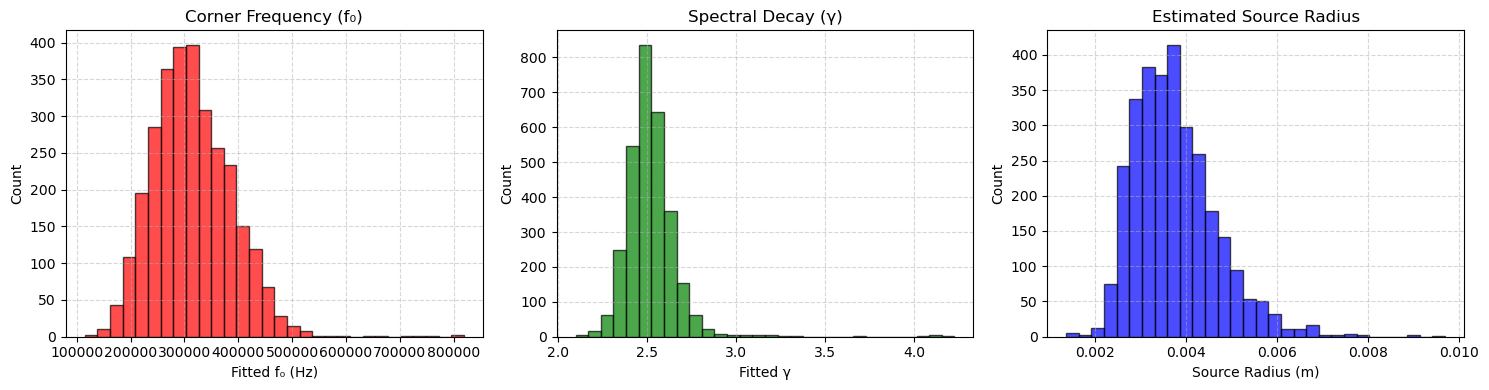

In [61]:
# --- Estimation of f0, gamma, and Source Radius from True Spectrum ---

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# === Load datasets ===

df_true_spectrum = pd.read_csv(os.path.join(folder_processed, "true_spectrum_results.csv"))
df_moment_magnitude = pd.read_csv(os.path.join(folder_processed, "moment_magnitude_results.csv"))

# ===================================

#set up frequency range
freq_min, freq_max = 10**4.7, 1e7 #update if needed; freq. range covering flat and decayed spectrum

# Sstorage for results
results = {
    "waveform_num": [],
    "fitted_f0": [],
    "fitted_gamma": [],
    "source_radius": []
}

# Iterate over each unique waveform
for waveform_num in tqdm(df_true_spectrum["waveform_num"].unique(), desc="Processing waveforms", unit="waveform"):
    spectrum_data = df_true_spectrum[df_true_spectrum["waveform_num"] == waveform_num]
    moment_data = df_moment_magnitude[df_moment_magnitude["waveform_num"] == waveform_num]

    if spectrum_data.empty or moment_data.empty:
        continue

    mean_M0 = moment_data["mean_M0"].values[0]
    delta_p_equiv = mean_M0 / C_FM

    # Prepare frequency and amplitude
    freqs = spectrum_data["frequency"].values
    amps = spectrum_data["true_spectrum"].values

    # Filter out invalid frequencies
    valid_mask = freqs > 0
    freqs = freqs[valid_mask]
    amps = amps[valid_mask]

    # Convert to log-log space
    log_freqs = np.log10(freqs)
    log_amps = np.log10(np.maximum(amps, 1e-12))

    # Apply fitting frequency range
    fit_mask = (freqs >= freq_min) & (freqs <= freq_max)
    fit_log_freqs = log_freqs[fit_mask]
    fit_log_amps = log_amps[fit_mask]

    if len(fit_log_freqs) < 2:
        continue

    # Define Brune model (in log-log space)
    def brune_model_log(params, log_f):
        log_M0, log_f0, gamma = params
        return log_M0 - np.log10(1 + (10**log_f / 10**log_f0)**gamma)

    def loss(params, log_f, log_spectrum):
        return np.sum((brune_model_log(params, log_f) - log_spectrum) ** 2)

    # Fit parameters
    init_params = [np.log10(1e-3), np.log10(10**5.5), 5] #initial guess of M0, f0, gamma
    bounds = [(np.log10(1e-8), np.log10(1e5)), (np.log10(1e4), np.log10(1e6)), (0, 15)] #bound guess of M0, f0, gamma

    result = minimize(loss, init_params, args=(fit_log_freqs, fit_log_amps), bounds=bounds)

    if not result.success:
        continue

    # Extract and convert fitted parameters
    _, log_f0, gamma = result.x
    f0 = 10**log_f0
    radius = (kappa * v_s) / (2 * np.pi * f0)

    # Store results
    results["waveform_num"].append(waveform_num)
    results["fitted_f0"].append(f0)
    results["fitted_gamma"].append(gamma)
    results["source_radius"].append(radius)

# Save to CSV
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(folder_processed, "fitted_brune_parameters.csv"), index=False)
print("Fitted parameters saved.")

# Plot histograms
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(results["fitted_f0"], bins=30, color="red", alpha=0.7, edgecolor="black")
plt.xlabel("Fitted f₀ (Hz)"); plt.ylabel("Count"); plt.title("Corner Frequency (f₀)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(1, 3, 2)
plt.hist(results["fitted_gamma"], bins=30, color="green", alpha=0.7, edgecolor="black")
plt.xlabel("Fitted γ"); plt.ylabel("Count"); plt.title("Spectral Decay (γ)")
plt.grid(True, linestyle="--", alpha=0.5)

plt.subplot(1, 3, 3)
plt.hist(results["source_radius"], bins=30, color="blue", alpha=0.7, edgecolor="black")
plt.xlabel("Source Radius (m)"); plt.ylabel("Count"); plt.title("Estimated Source Radius")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
